# 시계열 예측
## 런타임유형 확인


In [0]:
!curl https://raw.githubusercontent.com/neelabhpant/Deep-Learning-in-Python/master/USD_INR.csv \
  -o USD_INR.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  550k  100  550k    0     0   796k      0 --:--:-- --:--:-- --:--:--  796k


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Get the dataset and prepare it for analysis and model

#### Set the index to date

In [0]:
df = pd.read_csv('USD_INR.csv')
df['Date'] = pd.to_datetime(df["Date"])
df_idx = df.set_index(["Date"], drop=True)
df_idx.head(5)

,Price,Open,High,Low,Change %
Date,,,,,
2017-08-10,64.165,63.898,64.175,63.855,0.48
2017-08-09,63.860,63.780,63.860,63.710,0.26
2017-08-08,63.692,63.750,63.785,63.615,-0.23
2017-08-07,63.840,63.710,63.865,63.648,0.26
2017-08-04,63.675,63.670,63.786,63.572,-0.05


#### Flip the dataframe

In [0]:
df_idx = df_idx.sort_index(axis=1, ascending=True)
df_idx = df_idx.iloc[::-1]

#### Plot the data

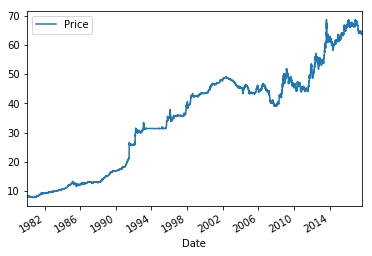

In [0]:
data = df_idx[['Price']]
data.plot(y='Price')

In [0]:
diff = data.index.values[-1] - data.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 1980 to %d"%(1980 + int(0.8*years)))

Total data: 37 years
80 percent data = 1980 to 2009


#### Create training and testing data

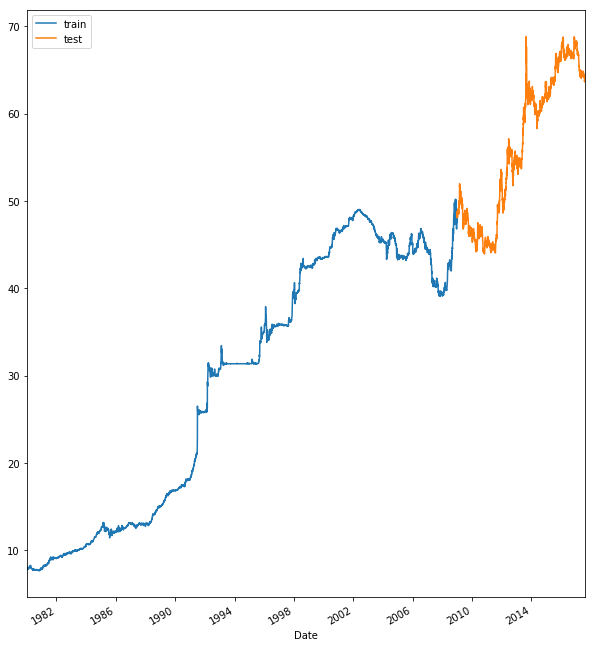

In [0]:
split_date = pd.Timestamp('01-01-2009')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

#### Normalize the dataset

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [0]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (7451 x 1)
Test size: (2245 x 1)


## Setup baseline model of SVM Regressor

In [0]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [0]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


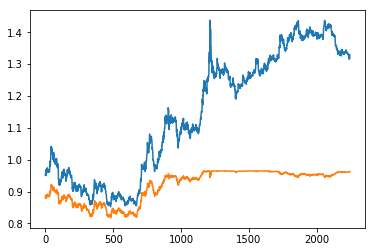

In [0]:
plt.plot(y_test)
plt.plot(y_pred)

In [0]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

R-squared is: -0.963381


## Build a Neural Network

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


### 1 hidden layer with 1 neuron

In [0]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

W0707 07:01:20.913163 139848455444352 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0707 07:01:20.915431 139848455444352 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0707 07:01:20.967070 139848455444352 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 07:01:20.971652 139848455444352 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W070

Epoch 1/20
7451/7451 [==============================] - 5s 656us/step - loss: 0.2985
Epoch 2/20
7451/7451 [==============================] - 1s 129us/step - loss: 0.0943
Epoch 3/20
7451/7451 [==============================] - 1s 129us/step - loss: 0.0658
Epoch 4/20
7451/7451 [==============================] - 1s 130us/step - loss: 0.0486
Epoch 5/20
7451/7451 [==============================] - 1s 129us/step - loss: 0.0333
Epoch 6/20
7451/7451 [==============================] - 1s 131us/step - loss: 0.0212
Epoch 7/20
7451/7451 [==============================] - 1s 130us/step - loss: 0.0128
Epoch 8/20
7451/7451 [==============================] - 1s 129us/step - loss: 0.0076
Epoch 9/20
7451/7451 [==============================] - 1s 129us/step - loss: 0.0048
Epoch 10/20
7451/7451 [==============================] - 1s 130us/step - loss: 0.0034
Epoch 11/20
7451/7451 [==============================] - 1s 132us/step - loss: 0.0027
Epoch 12/20
7451/7451 [==============================] - 1s 134

R-Squared: -1.164032


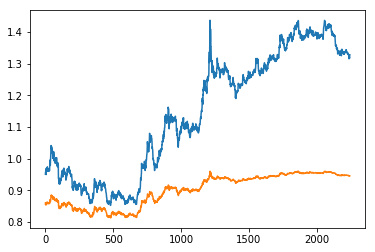

In [0]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

#### 2 Hidden Layers with 50 neurons each and ReLU activation function

In [0]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
7451/7451 [==============================] - 1s 199us/step - loss: 0.0043
Epoch 2/20
7451/7451 [==============================] - 1s 173us/step - loss: 1.0874e-05
Epoch 3/20
7451/7451 [==============================] - 1s 170us/step - loss: 1.0727e-05
Epoch 4/20
7451/7451 [==============================] - 1s 165us/step - loss: 1.1965e-05
Epoch 5/20
7451/7451 [==============================] - 1s 169us/step - loss: 1.2134e-05
Epoch 6/20
7451/7451 [==============================] - 1s 168us/step - loss: 1.3941e-05
Epoch 7/20
7451/7451 [==============================] - 1s 168us/step - loss: 1.4307e-05
Epoch 8/20
7451/7451 [==============================] - 1s 167us/step - loss: 1.9187e-05
Epoch 9/20
7451/7451 [==============================] - 1s 168us/step - loss: 1.6979e-05
Epoch 10/20
7451/7451 [==============================] - 1s 174us/step - loss: 2.2519e-05
Epoch 11/20
7451/7451 [==============================] - 1s 170us/step - loss: 1.6277e-05
Epoch 12/20
7451/7451 [

R-Squared: 0.998666


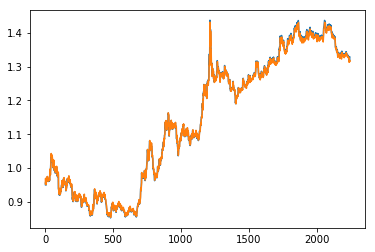

In [0]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

## Try to predict the difference between consecutive days
### This is also known as introducing stationarity in the dataset.
### A better test of the model is to predict stationarized data where the mean, standard deviation, autocorrelation are constant over time.
### Because stock price data, currency exchange etc. are generated using a completely stochastic random walk process. Being able to predict future outcomes of a stochastic process is by definition not possible, and if someone claims to do this, one should be a bit skeptical [Vegard Flovik, PhD]